In [5]:
%load_ext autoreload
%autoreload 2

## Instal·lant dependències

In [1]:
import os
from fastai import *
from fastai.text import *

import numpy as np
import pandas as pd


from functools import partial

In [3]:
!nvidia-smi

Wed Aug 19 13:35:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 745     Off  | 00000000:01:00.0  On |                  N/A |
| 25%   57C    P0    N/A /  N/A |    238MiB /  4040MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
torch.cuda.is_available()

True

# Entrenar el Language Model

Hem usat com a dataset tot el text que s'ha trobat en el repositori https://github.com/Softcatala/ca-text-corpus. També hem provat d'entrenar amb un dataset creat a partir del script **./get_wikimedia.sh** però ens tornava un dataset massa brut. 

In [54]:
import re
import html 
re1 = re.compile(r'  +')
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [62]:
wikipedia_short = fixup(open('wikimedia/corpus.ca.txt').read()).splitlines()

In [63]:
wikipedia_short[:100]

['Bona setmana.',
 'A quina hora comença el concert?',
 'A la ràdio han dit que demà plourà.',
 'No tenim res per sopar.',
 'A veure si quedem un dia per dinar.',
 'Fa molt de temps que no ens veiem.',
 'Quina calor.',
 'No sabem per què avui no ha vingut a treballar.',
 'Engega el ventilador.',
 "Aquest partit no s'acaba mai.",
 'Quin pal de pel·lícula.',
 "Quedem a les vuit a l'estació.",
 "Si acabo d'hora, aniré a mirar roba.",
 'Necessitem vacances.',
 'La setmana que ve anem a viure al pis nou.',
 'Què vas fer ahir a la tarda?',
 "Volia fer molta feina i entre una cosa i l'altra no vaig fer res de bo.",
 'Sempre vol tenir raó.',
 'La nena vol tocar el violí.',
 'Ets una mica sòmines, però em fas riure.',
 "M'agrada quan fas el pi pont a la gespa.",
 'És un cas, anem a la platja i es deixa el banyador.',
 "T'agraden totes?",
 'La Raquel porta una brusa de niló.',
 'Em busca les pessigolles, però no sap que tinc molta paciència.',
 "L'Adela em fa anar de corcoll i me n'he enamorat."

In [64]:
PERCENTAGE = 0.85
with open('train.csv','w') as f:
    for line in wikipedia_short[:int(len(wikipedia_short)*PERCENTAGE)]:
        f.write('{}, False\n'.format(line))
        
with open('valid.csv','w') as f:
    for line in wikipedia_short[int(len(wikipedia_short)*PERCENTAGE):]:
        f.write('{}, True\n'.format(line))

In [65]:
PATH = '.'
train = pd.read_csv(os.path.join(PATH, 'train.csv'), header=None, names=['label', 'content'])
valid = pd.read_csv(os.path.join(PATH, 'valid.csv'), header=None, names=['label', 'content'])

In [66]:
train['is_valid'] = False
valid['is_valid'] = True

In [67]:
df_train = train[['content', 'is_valid']]
df_valid = valid[['content', 'is_valid']]

In [68]:
df_regroup = pd.concat([df_train, df_valid])
df_regroup = df_regroup.dropna()

In [69]:
df_regroup.to_csv(os.path.join(PATH, 'fulltrain.csv'), header=None, index=None)

In [70]:
tokenizer = Tokenizer(lang='ca', n_cpus=6)

In [71]:
data_lm_full = (TextList.from_csv(PATH, csv_name='fulltrain.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)])
               .split_from_df(col=1)
               .label_for_lm()
               .databunch(bs=64))

/home/adria/DeepCatalan/env/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [40]:
data_lm_full.save('full_lm_30k')

In [6]:
data_lm_full = load_data(PATH, 'full_lm_30k', bs=16)

In [38]:
len(data_lm_full.train_ds.vocab.itos)
pickle.dump(data_lm_full.train_ds.vocab.itos, open('models/itos.pkl', 'wb'))

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'false',
 '.',
 'de',
 'i',
 'la',
 'a',
 'el',
 "l'",
 'en',
 "d'",
 'que',
 'va',
 'un',
 'amb',
 'del',
 'per',
 'les',
 'una',
 'els',
 'es',
 'al',
 'és',
 'no',
 '-',
 'com',
 'però',
 'més',
 "s'",
 'dels',
 'ha',
 'o',
 'ser',
 'hi',
 'seu',
 'seva',
 'també',
 '"',
 'van',
 'se',
 'on',
 'són',
 'molt',
 'als',
 'altres',
 'dos',
 'era',
 'tot',
 'cap',
 'ja',
 'entre',
 'part',
 'aquest',
 'gran',
 'fou',
 'aquesta',
 'nord',
 'pot',
 'estat',
 'sud',
 'seus',
 'encara',
 'té',
 'sense',
 'tres',
 'dues',
 'sobre',
 'fins',
 'pel',
 'qual',
 'li',
 'tant',
 'després',
 'està',
 'planta',
 'fer',
 'només',
 'forma',
 'han',
 'ciutat',
 'sant',
 'havia',
 'nom',
 'si',
 'durant',
 'així',
 'seves',
 'tots',
 'anys',
 'est',
 'clima',
 'pis']

In [44]:
data_lm_full.show_batch()

/home/adria/DeepCatalan/env/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj
1,xxmaj false xxbos que queda dispers després de l' explosió . xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos a xxmaj nou xxmaj mèxic . xxbos xxmaj false xxbos convertint - se en el mànager . xxbos xxmaj false xxbos xxmaj false xxbos sobretot de sardines xxbos xxmaj false xxbos xxmaj false xxbos els llançaments es succeeixen un a un fins a
2,xxbos a l' oest del país . xxbos xxmaj false xxbos epònima de la ciutat italiana de xxmaj màntua . xxbos xxmaj false xxbos xxmaj false xxbos el rei va condemnar - los a mort . xxbos o bé de xxmaj fènix . xxbos xxmaj false xxbos gelosa dels seus fillastres xxbos els xxunk les van perseguir fins a matar - ne dues de les tres . xxbos com el
3,false xxbos xxmaj false xxbos a xxmaj dinamarca . xxbos xxmaj false xxbos continua les seves activitats . xxbos xxmaj false xxbos de fet xxbos però xxbos per un problema de salut . xxbos xxmaj false xxbos després d' un període de càstig xxbos xxmaj false xxbos pateix d' una profunda falta de continuïtat en la cronologia . xxbos xxmaj false xxbos xxmaj false xxbos així com la xifra de
4,xxbos xxmaj false xxbos va bombardejar i capturar xxmaj cartagena i xxmaj alacant . xxbos xxmaj false xxbos xxmaj false xxbos al sud - oest del xxmaj rieral de xxmaj bigues . xxbos cos dansant i arquitectura . xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos xxmaj false xxbos mengen carronya xxbos xxmaj false xxbos i l' xxunk menorquí . xxbos xxmaj false xxbos xxmaj menorca i xxmaj


In [9]:
learn = language_model_learner(data_lm_full, arch=AWD_LSTM, drop_mult=0, callback_fns=ShowGraph)

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


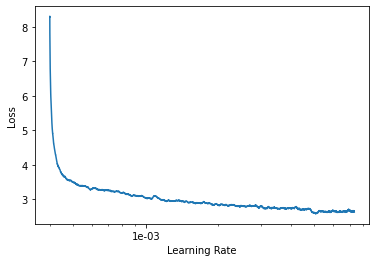

In [72]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.516127,2.721565,0.531731,43:50


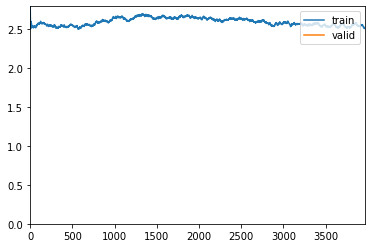

In [73]:
learn.fit_one_cycle(1, 1e-02)

In [74]:
np.exp(2.721565)

15.20409804898121

In [75]:
learn.save('model-30k-vocab')

# Finetuning a un classificador de text

## Dataset: Notícies scrapejades amb el seu tipus

In [77]:
data = pd.read_csv('data.csv', delimiter='|', error_bad_lines=False)
data

,Type,Article
0,SPORTS,Una terrible calamarsada ha castigat aquest di...
1,SPORTS,La bona resposta de l'afició ha acabat donant ...
2,SPORTS,Frida Eldebrink i Giedre Labuckiene (foto) es ...
3,SPORTS,"Barça i Bayern de Munic, els dos únics campion..."
4,SPORTS,L'equip Racing Point de Fórmula 1 va anunciar ...
...,...,...
59,SALUT,Les comarques gironines han registrat 9.263 ca...
60,SALUT,Les proves clíniques de la vacuna contra la co...
61,SALUT,Un equip d'investigadors del Consell Superior ...
62,SALUT,Un estudi dirigit per la Charité - Universität...


In [20]:
data.shape

(64, 2)

In [78]:
data['Article'] = data['Article'].str.replace("[^a-zA-Z]", " ")
data = data.dropna()
data.to_csv(os.path.join(PATH, 'train_news.csv'), header=None, index=None)

## Preprocessing: Tokenitzar i estandaritzarització

In [79]:
PATH_LM = Path('.')
PATH_CS = Path('.')

In [80]:
tokenizer = Tokenizer(lang='ca', n_cpus=6)
data_lm = TextLMDataBunch.from_csv(PATH_LM, tokenizer=tokenizer, bs=16, csv_name='train_news.csv')

/home/adria/DeepCatalan/env/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [81]:
data_lm.save('data_lm')

In [82]:
data_lm = load_data(PATH_LM, 'data_lm', bs=64)

## Carregar els weights del Language Model

In [88]:
weights_pretrained='model-30k-vocab'
itos_pretrained='itos'
pretrained_data=(weights_pretrained, itos_pretrained)

In [89]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretrained_data, drop_mult=0)
learn.freeze()

## Finetuning del Language Model en la nostra data

Primer, abans d'entrenar el classificador (només fent servir l'encoder) fem *fine-tuning* amb la nostra data. Tot i que el model ha estat entrenat amb un dataset de domini-general molt divers, probablement la nostra data té una distribució diferent.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


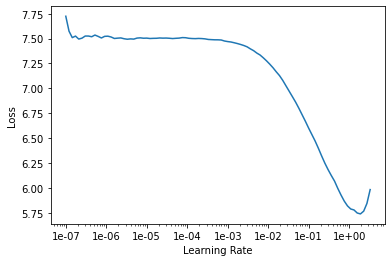

In [90]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [ ]:
learn.fit_one_cycle(1,1e-2)

In [ ]:
learn.save('head_pretrained')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('lm_fine_tuned')
learn.save_encoder('ft_enc')

## Finetuning de l'encoder

Ara toca entrenar el classificador utilitzant només l'encoder. 

In [ ]:
data_class = TextClassDataBunch.from_csv(PATH_CS, vocab=data_lm.train_ds.vocab, bs=16, csv_name='new_train.csv', tokenizer=tokenizer)

In [ ]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')
learn.freeze

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_strat=0)

In [91]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(2152, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(2152, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=2152, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
learn.fit_one_cycle(2, 1e-2, moms(0.8,0.7))

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.fit_once_cycle(1, slice(5e-3/(2.6**4), 5e-3), momds=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_once_cycle(2, slice(1e-3/(2.6**4), 1e-3), momds=(0.8,0.7))